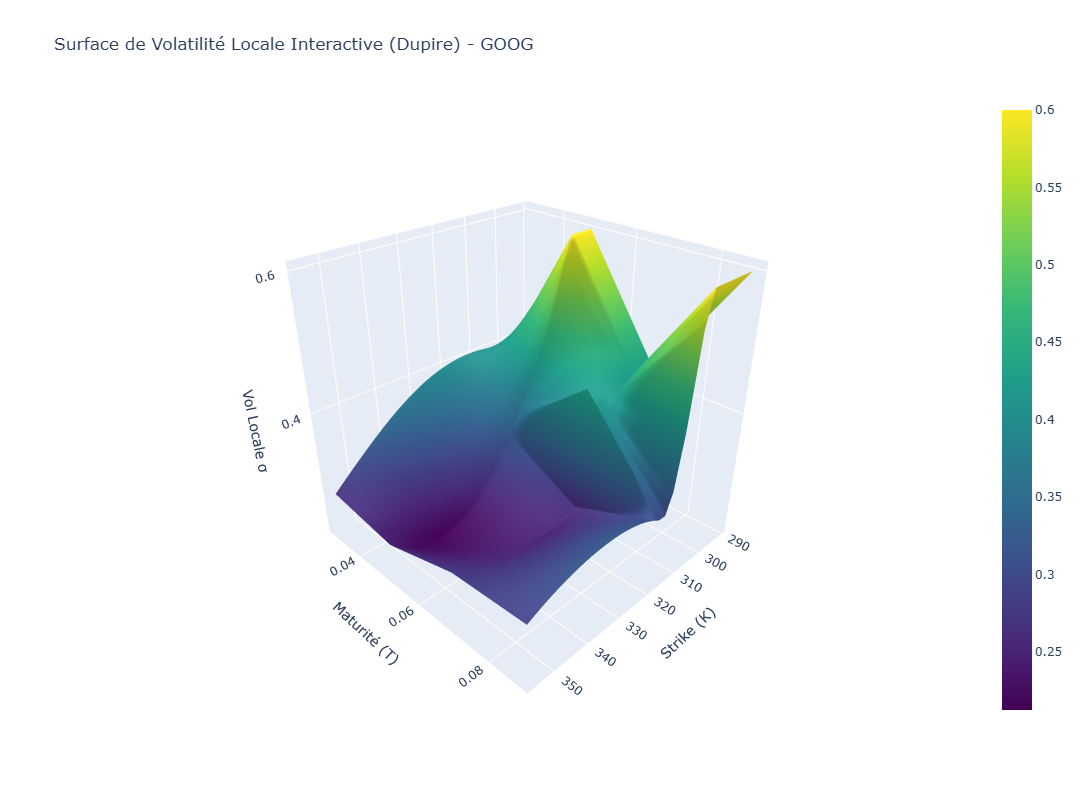

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import CubicSpline

# --- 1. FONCTIONS DE PRICING ET VOLATILITÉ ---

def black_scholes_call(S, K, T, r, sigma):
    if T <= 0: return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def implied_volatility(price, S, K, T, r):
    if price <= max(S - K, 0): return np.nan
    try:
        # On cherche sigma tel que BS(sigma) = Prix marché
        return brentq(lambda sig: black_scholes_call(S, K, T, r, sig) - price, 1e-6, 5.0)
    except: return np.nan

# --- 2. RÉCUPÉRATION DES DONNÉES ET LISSAGE DU SMILE ---

ticker_symbol = "GOOG" # Tu peux changer par "TSLA" ou "^SPX"
data = yf.Ticker(ticker_symbol)
S = data.history(period="1d")['Close'].iloc[-1]
r = 0.045
expirations = data.options[:6] # On prend les 6 prochaines maturités

splines_dict = {}
valid_times = []

for exp in expirations:
    chain = data.option_chain(exp)
    calls = chain.calls[['strike', 'lastPrice']].dropna()
    # On reste proche de la monnaie pour la stabilité (85% - 115% du prix spot)
    calls = calls[(calls['strike'] > S * 0.85) & (calls['strike'] < S * 1.15)]
    
    T = (pd.to_datetime(exp) - pd.Timestamp.now()).days / 365.0
    if T <= 0.02 or len(calls) < 8: continue # On ignore les maturités trop courtes

    # Calcul de la Vol Implicite et lissage polynomial (degré 2)
    strikes = calls['strike'].values
    vols = [implied_volatility(p, S, k, T, r) for p, k in zip(calls['lastPrice'], strikes)]
    
    mask = ~np.isnan(vols)
    if sum(mask) < 5: continue
    
    # On lisse la VOLATILITÉ pour éviter le bruit
    poly_fit = np.poly1d(np.polyfit(strikes[mask], np.array(vols)[mask], 2))
    
    # On génère des prix "lissés" à partir de cette vol lissée
    K_fine = np.linspace(strikes.min(), strikes.max(), 50)
    P_smooth = [black_scholes_call(S, k, T, r, poly_fit(k)) for k in K_fine]
    
    # On crée la Spline Cubique sur ces prix parfaits
    splines_dict[T] = CubicSpline(K_fine, P_smooth, bc_type='natural')
    valid_times.append(T)

valid_times.sort()

# --- 3. CALCUL DE LA SURFACE DE DUPIRE ---

def get_local_vol(K, T1, T2):
    cs1, cs2 = splines_dict[T1], splines_dict[T2]
    dt = T2 - T1
    
    dCdT = (cs2(K) - cs1(K)) / dt      # Dérivée temporelle
    dCdK = cs2(K, nu=1)               # Dérivée 1ère / Strike
    d2CdK2 = cs2(K, nu=2)             # Dérivée 2nde / Strike (Densité)
    
    num = dCdT + r * K * dCdK
    den = 0.5 * (K**2) * d2CdK2
    
    if den <= 1e-9 or num <= 0: return np.nan
    return np.sqrt(num / den)

# Grille de strikes pour la surface
strikes_grid = np.linspace(S * 0.9, S * 1.1, 30)
T_mesh, K_mesh = np.meshgrid(valid_times[:-1], strikes_grid)
Z_vol = np.zeros(K_mesh.shape)

for i in range(len(valid_times) - 1):
    for j, k in enumerate(strikes_grid):
        Z_vol[j, i] = get_local_vol(k, valid_times[i], valid_times[i+1])

# Nettoyage final pour le rendu visuel
Z_vol = np.nan_to_num(Z_vol, nan=np.nanmean(Z_vol))
Z_vol = np.clip(Z_vol, 0.05, 0.6)

# --- 4. VISUALISATION INTERACTIVE (PLOTLY) ---

fig = go.Figure(data=[go.Surface(
    z=Z_vol, x=K_mesh, y=T_mesh, 
    colorscale='Viridis',
    hovertemplate='Strike: %{x}<br>Maturité: %{y}<br>Vol Locale: %{z:.2%}<extra></extra>'
)])

fig.update_layout(
    title=f'Surface de Volatilité Locale Interactive (Dupire) - {ticker_symbol}',
    scene=dict(
        xaxis_title='Strike (K)',
        yaxis_title='Maturité (T)',
        zaxis_title='Vol Locale σ',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
    ),
    width=1000, height=800
)

fig.show()